In [1]:
import codecs
import numpy as np
import copy
import time
import random
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import operator

load file...
Complete load. entity : 39 , relation : 9 , train triple : 71, , valid triple : 71
batch size:  14 valid_batch:  15
epoch:  0 cost time: 1.288
Train loss:  tensor(4.0666, device='cuda:0', grad_fn=<DivBackward0>) Valid loss:  tensor(3.8066, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  1 cost time: 0.058
Train loss:  tensor(3.8375, device='cuda:0', grad_fn=<DivBackward0>) Valid loss:  tensor(3.9778, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  2 cost time: 0.057
Train loss:  tensor(3.9577, device='cuda:0', grad_fn=<DivBackward0>) Valid loss:  tensor(3.8961, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  3 cost time: 0.061
Train loss:  tensor(3.5536, device='cuda:0', grad_fn=<DivBackward0>) Valid loss:  tensor(3.9774, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  4 cost time: 0.067
Train loss:  tensor(3.1070, device='cuda:0', grad_fn=<DivBackward0>) Valid loss:  tensor(3.8610, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  5 cost time: 0.061
Train loss:  tensor

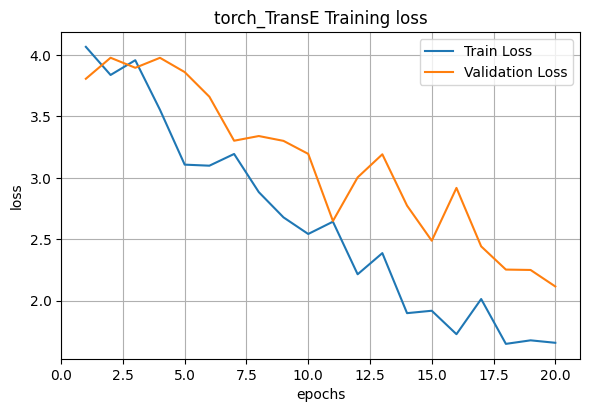

1 [29, 6, 19]
epoch:  1 cost time: 0.003 1.0 5.5
2 [14, 6, 19]
epoch:  2 cost time: 0.002 1.0 5.25
3 [4, 6, 19]
epoch:  3 cost time: 0.003 1.0 4.666666666666667
4 [10, 6, 19]
epoch:  4 cost time: 0.004 1.0 4.375
5 [18, 6, 19]
epoch:  5 cost time: 0.004 1.0 4.0
6 [14, 6, 33]
epoch:  6 cost time: 0.001 1.0 4.083333333333333
7 [4, 6, 33]
epoch:  7 cost time: 0.006 1.0 3.642857142857143
8 [10, 6, 33]
epoch:  8 cost time: 0.001 1.0 3.5625
9 [18, 6, 33]
epoch:  9 cost time: 0.001 1.0 3.4444444444444446
10 [4, 6, 33]
epoch:  10 cost time: 0.008 1.0 3.2
11 [29, 4, 21]
epoch:  11 cost time: 0.001 0.9545454545454546 3.590909090909091
12 [38, 4, 21]
epoch:  12 cost time: 0.001 0.9583333333333334 3.5
13 [10, 4, 21]
epoch:  13 cost time: 0.008 0.9615384615384616 3.5
14 [18, 4, 21]
epoch:  14 cost time: 0.001 0.9285714285714286 4.107142857142857
15 [23, 4, 21]
epoch:  15 cost time: 0.001 0.9 4.3
16 [29, 4, 1]
epoch:  16 cost time: 0.006 0.90625 4.28125
17 [38, 4, 1]
epoch:  17 cost time: 0.001 0.911

In [2]:


# 全局变量
entities2id = {}
relations2id = {}
relation_tph = {}
relation_hpt = {}


def dataloader(file1, file2, file3, file4):
    print("load file...")

    entity = []
    relation = []
    with open(file2, 'r') as f1, open(file3, 'r') as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()
        for line in lines1:
            line = line.strip().split('\t')
            if len(line) != 2:
                continue
            entities2id[line[0]] = line[1]
            entity.append(int(line[1]))

        for line in lines2:
            line = line.strip().split('\t')
            if len(line) != 2:
                continue
            relations2id[line[0]] = line[1]
            relation.append(int(line[1]))

    triple_list = []
    relation_head = {} # 关系与头实体的字典集合计数
    relation_tail = {} # 关系与尾实体的字典集合计数

    with codecs.open(file1, 'r') as f:
        content = f.readlines()
        for line in content:
            triple = line.strip().split("\t")
            if len(triple) != 3:
                continue

            h_ = int(entities2id[triple[0]])
            r_ = int(relations2id[triple[1]])
            t_ = int(entities2id[triple[2]])

            # 对关系和头实体的集合计数
            triple_list.append([h_, r_, t_])
            if r_ in relation_head:
                if h_ in relation_head[r_]:
                    relation_head[r_][h_] += 1
                else:
                    relation_head[r_][h_] = 1
            else:
                relation_head[r_] = {}
                relation_head[r_][h_] = 1

            # 对关系和尾实体的集合计数
            if r_ in relation_tail:
                if t_ in relation_tail[r_]:
                    relation_tail[r_][t_] += 1
                else:
                    relation_tail[r_][t_] = 1
            else:
                relation_tail[r_] = {}
                relation_tail[r_][t_] = 1
    # 计算每个关系平均头实体数
    for r_ in relation_head:
        sum1, sum2 = 0, 0
        for head in relation_head[r_]:
            sum1 += 1
            sum2 += relation_head[r_][head]
        tph = sum2 / sum1
        relation_tph[r_] = tph
    # 计算每个关系平均尾实体数
    for r_ in relation_tail:
        sum1, sum2 = 0, 0
        for tail in relation_tail[r_]:
            sum1 += 1
            sum2 += relation_tail[r_][tail]
        hpt = sum2 / sum1
        relation_hpt[r_] = hpt
    # 获得验证集的三元组集合
    valid_triple_list = []
    with codecs.open(file4, 'r') as f:
        content = f.readlines()
        for line in content:
            triple = line.strip().split("\t")
            if len(triple) != 3:
                continue

            h_ = int(entities2id[triple[0]])
            r_ = int(relations2id[triple[1]])
            t_ = int(entities2id[triple[2]])

            valid_triple_list.append([h_, r_, t_])

    print("Complete load. entity : %d , relation : %d , train triple : %d, , valid triple : %d" % (
        len(entity), len(relation), len(triple_list), len(valid_triple_list)))

    return entity, relation, triple_list, valid_triple_list


def norm_l1(h, r, t):
    return np.sum(np.fabs(h + r - t))


def norm_l2(h, r, t):
    return np.sum(np.square(h + r - t))


class E(nn.Module):
    def __init__(self, entity_num, relation_num, dim, margin, norm, C):
        super(E, self).__init__()
        self.entity_num = entity_num
        self.relation_num = relation_num
        self.dim = dim
        self.margin = margin
        self.norm = norm
        self.C = C
        # 初始化 实体数量*维度的词嵌入 14951*50  关系数量*维度的词嵌入 1345*50
        # nn.Embedding.weight随机初始化方式是标准正态分布
        self.ent_embedding = torch.nn.Embedding(num_embeddings=self.entity_num,
                                                embedding_dim=self.dim).cuda()
        self.rel_embedding = torch.nn.Embedding(num_embeddings=self.relation_num,
                                                embedding_dim=self.dim).cuda()

        self.loss_F = nn.MarginRankingLoss(self.margin, reduction="mean").cuda()  # 计算两个向量之间的相似度，当两个向量之间的距离大于margin，则loss为正，小于margin，loss为0

        self.__data_init()

    def __data_init(self):
        nn.init.xavier_uniform_(self.ent_embedding.weight.data) # Xavier 初始化
        nn.init.xavier_uniform_(self.rel_embedding.weight.data) # Xavier 初始化
        self.normalization_rel_embedding()
        self.normalization_ent_embedding()

    def normalization_ent_embedding(self):
        norm = self.ent_embedding.weight.detach().cpu().numpy() # 转换成numpy的格式
        # norm:(14951,50)  norm/(norm平方加起来再开平方)  axis=1是对1这个维度进行计算，也就是保留14951的维度
        # 为了能做除法，所以keepdims=True
        # 这一步的分母是在计算L2范数，进行L2范数归一化
        norm_weight = np.sqrt(np.sum(np.square(norm), axis=1, keepdims=True))
        # norm_weight:(14951,1)
        norm = norm / norm_weight

        self.ent_embedding.weight.data.copy_(torch.from_numpy(norm))

    def normalization_rel_embedding(self):
        norm = self.rel_embedding.weight.detach().cpu().numpy()
        norm = norm / np.sqrt(np.sum(np.square(norm), axis=1, keepdims=True))
        self.rel_embedding.weight.data.copy_(torch.from_numpy(norm))  # 把词向量矩阵作为参数复制过去

    def input_pre_transe(self, ent_vector, rel_vector):
        for i in range(self.entity_num):
            self.ent_embedding.weight.data[i] = torch.from_numpy(np.array(ent_vector[i]))
        for i in range(self.relation_num):
            self.rel_embedding.weight.data[i] = torch.from_numpy(np.array(rel_vector[i]))

    def distance(self, h, r, t):
        head = self.ent_embedding(h)
        rel = self.rel_embedding(r)
        tail = self.ent_embedding(t)

        distance = head + rel - tail
        # self.norm = 1就是一范数    dim=1：指定计算的维度   distance:(9600,50)
        score = torch.norm(distance, p=self.norm, dim=1) # torch.norm返回所给tensor的矩阵范数或向量范数
        return score

    def test_distance(self, h, r, t):

        head = self.ent_embedding(h.cuda()) # 找到对应的向量
        rel = self.rel_embedding(r.cuda())
        tail = self.ent_embedding(t.cuda())

        distance = head + rel - tail

        score = torch.norm(distance, p=self.norm, dim=1)
        return score.cpu().detach().numpy()

    def scale_loss(self, embedding):
        return torch.sum(
            torch.max(
                torch.sum(
                    embedding ** 2, dim=1, keepdim=True
                ) - torch.autograd.Variable(torch.FloatTensor([1.0]).cuda()),
                torch.autograd.Variable(torch.FloatTensor([0.0]).cuda())
            ))

    # 计算loss
    def forward(self, current_triples, corrupted_triples):
        h, r, t = torch.chunk(current_triples, 3, dim=1)  # chunk方法可以对张量分块，返回一个张量列表
        h_c, r_c, t_c = torch.chunk(corrupted_triples, 3, dim=1)

        h = torch.squeeze(h, dim=1).cuda() # squeeze()函数的功能是维度压缩。返回一个tensor（张量），其中input中大小为1的所有维都已删除
        r = torch.squeeze(r, dim=1).cuda()
        t = torch.squeeze(t, dim=1).cuda()
        h_c = torch.squeeze(h_c, dim=1).cuda()
        r_c = torch.squeeze(r_c, dim=1).cuda()
        t_c = torch.squeeze(t_c, dim=1).cuda()

        # pos:正确（头+关系-尾）的一范数    错误 neg:（头+关系-尾）的一范数
        pos = self.distance(h, r, t)
        neg = self.distance(h_c, r_c, t_c)

        entity_embedding = self.ent_embedding(torch.cat([h, t, h_c, t_c]).cuda()) # 实体嵌入
        relation_embedding = self.rel_embedding(torch.cat([r, r_c]).cuda())  # 关系嵌入

        y = Variable(torch.Tensor([-1])).cuda()
        # loss 计算正负三元组的距离，也就是（r+(d+)-(d-)）
        loss = self.loss_F(pos, neg, y)  # self.loss_F = nn.MarginRankingLoss(self.margin, reduction="mean").cuda()

        ent_scale_loss = self.scale_loss(entity_embedding) # 不懂这个是干什么的
        rel_scale_loss = self.scale_loss(relation_embedding)
        return loss + self.C * (ent_scale_loss / len(entity_embedding) + rel_scale_loss / len(relation_embedding))


class TransE:
    def __init__(self, entity, relation, triple_list, embedding_dim=50, lr=0.01, margin=1.0, norm=1, C=1.0,
                 valid_triple_list=None):
        self.entities = entity
        self.relations = relation
        self.triples = triple_list
        self.dimension = embedding_dim
        self.learning_rate = lr
        self.margin = margin
        self.norm = norm
        self.loss = 0.0
        self.valid_loss = 0.0
        self.valid_triples = valid_triple_list
        self.train_loss = []
        self.validation_loss = []

        self.test_triples = []

        self.C = C

    def data_initialise(self):
        # 创建一个模型,把向量放到里面作为优化的参数
        self.model = E(len(self.entities), len(self.relations), self.dimension, self.margin, self.norm, self.C)
        self.optim = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # self.optim = optim.SGD(self.model.parameters(), lr=self.learning_rate)

    def insert_pre_data(self, file1, file2):
        entity_dic = {}
        relation = {}
        with codecs.open(file1, 'r') as f1, codecs.open(file2, 'r') as f2:
            lines1 = f1.readlines()
            lines2 = f2.readlines()
            for line in lines1:
                line = line.strip().split('\t')
                if len(line) != 2:
                    continue
                entity_dic[int(line[0])] = json.loads(line[1])

            for line in lines2:
                line = line.strip().split('\t')
                if len(line) != 2:
                    continue
                relation[int(line[0])] = json.loads(line[1])

        self.model.input_pre_transe(entity_dic, relation)

    def insert_test_data(self, file1, file2, file3):
        self.insert_pre_data(file1, file2)

        triple_list = []
        with codecs.open(file3, 'r') as f4:
            content = f4.readlines()
            for line in content:
                triple = line.strip().split("\t")
                if len(triple) != 3:
                    continue

                head = int(entities2id[triple[0]])
                relation = int(relations2id[triple[1]])
                tail = int(entities2id[triple[2]])

                triple_list.append([head, relation, tail])

        self.test_triples = triple_list

    def insert_traning_data(self, file1, file2, file3):
        self.insert_pre_data(file1, file2)
        with codecs.open(file3, 'r') as f5:
            lines = f5.readlines()
            for line in lines:
                line = line.strip().split('\t')
                self.train_loss = json.loads(line[0])
                self.validation_loss = json.loads(line[1])
        print(self.train_loss, self.validation_loss)

    def training_run(self, epochs=20, batch_size=400, out_file_title=''):

        n_batches = int(len(self.triples) / batch_size)
        valid_batch = int(len(self.valid_triples) / batch_size) + 1
        print("batch size: ", n_batches, "valid_batch: ", valid_batch)
        for epoch in range(epochs):

            start = time.time()
            self.loss = 0.0
            self.valid_loss = 0.0
            # Normalise the embedding of the entities to 1

            for batch in range(n_batches):

                batch_samples = random.sample(self.triples, batch_size)

                current = []
                corrupted = []
                for sample in batch_samples:
                    corrupted_sample = copy.deepcopy(sample)
                    pr = np.random.random(1)[0]
                    p = relation_tph[int(corrupted_sample[1])] / (
                            relation_tph[int(corrupted_sample[1])] + relation_hpt[int(corrupted_sample[1])])
                    if pr < p:
                        # change the head entity
                        corrupted_sample[0] = random.sample(self.entities, 1)[0] # random.sample(self.entities）从entities中随机选择一个
                        while corrupted_sample[0] == sample[0]:  # 保证不是正好替换成了自己本身的三元组
                            corrupted_sample[0] = random.sample(self.entities, 1)[0]
                    else:
                        # change the tail entity
                        corrupted_sample[2] = random.sample(self.entities, 1)[0]
                        while corrupted_sample[2] == sample[2]: # 保证不是正好替换成了自己本身的三元组
                            corrupted_sample[2] = random.sample(self.entities, 1)[0]

                    current.append(sample)
                    corrupted.append(corrupted_sample)

                current = torch.from_numpy(np.array(current)).long() # torch.nn.embedding类的forward只接受longTensor类型的张量
                corrupted = torch.from_numpy(np.array(corrupted)).long() # torch.nn.embedding类的forward只接受longTensor类型的张量
                self.update_triple_embedding(current, corrupted)

            for batch in range(valid_batch):

                batch_samples = random.sample(self.valid_triples, batch_size)

                current = []
                corrupted = []
                for sample in batch_samples:
                    corrupted_sample = copy.deepcopy(sample)
                    pr = np.random.random(1)[0]
                    p = relation_tph[int(corrupted_sample[1])] / (
                            relation_tph[int(corrupted_sample[1])] + relation_hpt[int(corrupted_sample[1])])

                    if pr > p:
                        # change the head entity
                        corrupted_sample[0] = random.sample(self.entities, 1)[0]
                        while corrupted_sample[0] == sample[0]:
                            corrupted_sample[0] = random.sample(self.entities, 1)[0]
                    else:
                        # change the tail entity
                        corrupted_sample[2] = random.sample(self.entities, 1)[0]
                        while corrupted_sample[2] == sample[2]:
                            corrupted_sample[2] = random.sample(self.entities, 1)[0]

                    current.append(sample)
                    corrupted.append(corrupted_sample)

                current = torch.from_numpy(np.array(current)).long()
                corrupted = torch.from_numpy(np.array(corrupted)).long()
                self.calculate_valid_loss(current, corrupted)

            end = time.time()
            mean_train_loss = self.loss / n_batches
            mean_valid_loss = self.valid_loss / valid_batch
            print("epoch: ", epoch, "cost time: %s" % (round((end - start), 3)))
            print("Train loss: ", mean_train_loss, "Valid loss: ", mean_valid_loss)

            self.train_loss.append(float(mean_train_loss))
            self.validation_loss.append(float(mean_valid_loss))

        # visualize the loss as the network trained
        fig = plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(self.train_loss) + 1), self.train_loss, label='Train Loss')
        plt.plot(range(1, len(self.validation_loss) + 1), self.validation_loss, label='Validation Loss')

        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.xlim(0, len(self.train_loss) + 1)  # consistent scale
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.title(out_file_title + "TransE Training loss")
        plt.show()

        fig.savefig(out_file_title + 'TransE_loss_plot.png', bbox_inches='tight')

        with codecs.open(out_file_title + "TransE_entity_" + str(self.dimension) + "dim_batch" + str(batch_size),
                         "w") as f1:

            for i, e in enumerate(self.model.ent_embedding.weight):
                f1.write(str(i) + "\t")
                f1.write(str(e.cpu().detach().numpy().tolist()))  # tolist()将矩阵转化成列表
                f1.write("\n")

        with codecs.open(out_file_title + "TransE_relation_" + str(self.dimension) + "dim_batch" + str(batch_size),
                         "w") as f2:

            for i, e in enumerate(self.model.rel_embedding.weight):
                f2.write(str(i) + "\t")
                f2.write(str(e.cpu().detach().numpy().tolist()))
                f2.write("\n")

        with codecs.open(out_file_title + "loss_record.txt", "w") as f1:
            f1.write(str(self.train_loss) + "\t" + str(self.validation_loss))

    def update_triple_embedding(self, correct_sample, corrupted_sample):
        self.optim.zero_grad()
        loss = self.model(correct_sample, corrupted_sample)
        self.loss += loss
        loss.backward()
        self.optim.step()

    def calculate_valid_loss(self, correct_sample, corrupted_sample):
        loss = self.model(correct_sample, corrupted_sample)
        self.valid_loss += loss

    def test_run(self, filter=False):

        self.filter = filter
        hits = 0
        rank_sum = 0
        num = 0

        for triple in self.test_triples:
            start = time.time()
            num += 1
            print(num, triple)
            rank_head_dict = {}
            rank_tail_dict = {}
            #
            head_embedding = []
            tail_embedding = []
            norm_relation = []
            hyper_relation = []
            tamp = []

            head_filter = []
            tail_filter = []
            if self.filter:

                for tr in self.triples:
                    if tr[1] == triple[1] and tr[2] == triple[2] and tr[0] != triple[0]:
                        head_filter.append(tr)
                    if tr[0] == triple[0] and tr[1] == triple[1] and tr[2] != triple[2]:
                        tail_filter.append(tr)
                for tr in self.test_triples:
                    if tr[1] == triple[1] and tr[2] == triple[2] and tr[0] != triple[0]:
                        head_filter.append(tr)
                    if tr[0] == triple[0] and tr[1] == triple[1] and tr[2] != triple[2]:
                        tail_filter.append(tr)
                for tr in self.valid_triples:
                    if tr[1] == triple[1] and tr[2] == triple[2] and tr[0] != triple[0]:
                        head_filter.append(tr)
                    if tr[0] == triple[0] and tr[1] == triple[1] and tr[2] != triple[2]:
                        tail_filter.append(tr)

            for i, entity in enumerate(self.entities): # 遍历所有实体，计算距离

                head_triple = [entity, triple[1], triple[2]]
                if self.filter:
                    if head_triple in head_filter:
                        continue
                head_embedding.append(head_triple[0])
                norm_relation.append(head_triple[1])
                tail_embedding.append(head_triple[2])

                tamp.append(tuple(head_triple))

            head_embedding = torch.from_numpy(np.array(head_embedding)).long()
            norm_relation = torch.from_numpy(np.array(norm_relation)).long()
            tail_embedding = torch.from_numpy(np.array(tail_embedding)).long()
            distance = self.model.test_distance(head_embedding, norm_relation, tail_embedding)

            for i in range(len(tamp)):
                rank_head_dict[tamp[i]] = distance[i]

            head_embedding = []
            tail_embedding = []
            norm_relation = []
            hyper_relation = []
            tamp = []

            for i, tail in enumerate(self.entities):

                tail_triple = [triple[0], triple[1], tail]
                if self.filter:
                    if tail_triple in tail_filter:
                        continue
                head_embedding.append(tail_triple[0])
                norm_relation.append(tail_triple[1])
                tail_embedding.append(tail_triple[2])
                tamp.append(tuple(tail_triple))

            head_embedding = torch.from_numpy(np.array(head_embedding)).long()
            norm_relation = torch.from_numpy(np.array(norm_relation)).long()
            tail_embedding = torch.from_numpy(np.array(tail_embedding)).long()

            distance = self.model.test_distance(head_embedding, norm_relation, tail_embedding)
            for i in range(len(tamp)):
                rank_tail_dict[tamp[i]] = distance[i]

            rank_head_sorted = sorted(rank_head_dict.items(), key=operator.itemgetter(1), reverse=False)
            rank_tail_sorted = sorted(rank_tail_dict.items(), key=operator.itemgetter(1), reverse=False)

            # calculate the mean_rank and hit_10
            # head data
            i = 0
            for i in range(len(rank_head_sorted)):
                if triple[0] == rank_head_sorted[i][0][0]:
                    if i < 10:
                        hits += 1
                    rank_sum = rank_sum + i + 1
                    break

            # tail rank
            i = 0
            for i in range(len(rank_tail_sorted)):
                if triple[2] == rank_tail_sorted[i][0][2]:
                    if i < 10:
                        hits += 1
                    rank_sum = rank_sum + i + 1
                    break
            end = time.time()
            print("epoch: ", num, "cost time: %s" % (round((end - start), 3)), str(hits / (2 * num)),
                  str(rank_sum / (2 * num)))
        self.hit_10 = hits / (2 * len(self.test_triples))
        self.mean_rank = rank_sum / (2 * len(self.test_triples))
        print("hits@10: ", self.hit_10)
        print("meanrank: ", self.mean_rank)
        f = open("./result.txt", 'w')
        f.write("hits@10: " + str(self.hit_10) + '\n')
        f.write("meanrank: " + str(self.mean_rank) + '\n')
        f.close()
        return self.hit_10, self.mean_rank


if __name__ == '__main__':


    file1 = "DATA/train.txt"
    file2 = "DATA/entity2id.txt"
    file3 = "DATA/relation2id.txt"
    file4 = "DATA/valid.txt"


    file5 = "torch_TransE_entity_50dim_batch5"
    file6 = "torch_TransE_relation_50dim_batch5"

    file8 = "DATA/test.txt"
    # file9 = "Fb15k_loss_record.txt"
    entity_set, relation_set, triple_list, valid_triple_list = dataloader(file1, file2, file3, file4)

    transE = TransE(entity_set, relation_set, triple_list, embedding_dim=50, lr=0.001, margin=4.0, norm=1, C = 0.25, valid_triple_list=valid_triple_list)
    transE.data_initialise()
    transE.training_run(epochs=20, batch_size=5, out_file_title="torch_")
    transE.insert_test_data(file5, file6, file8)

    transE.test_run(filter=False)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')